**Introduction**: This project applies an unsupervised learning approach to detect whether an image is AI-generated (fake) or real, without relying on labels during training. Using KMeans clustering on normalized image embeddings, we identify natural groupings in the training data, with the optimal number of clusters selected via the Elbow Method.

Each test image is assigned to the nearest cluster based on Euclidean distance, and classified using majority voting from that cluster’s training labels. Model performance is evaluated using a confusion matrix, classification report, and precision-recall curves to assess its ability to distinguish fake from real images.


Mount the Google Drive in a Google Colab environment



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%%capture
!pip install torch==2.5.0 torchvision ftfy regex tqdm git+https://github.com/openai/CLIP.git

#Read the embeddings dataframe

In [13]:
import pandas as pd
import numpy as np
import torch

def string_to_float_array(s):
    s = s.replace('[', '').replace(']', '')
    return np.array([float(x) for x in s.split(',')])

df_embeddings = pd.read_csv('drive/MyDrive/colab_notebooks/embeddings.csv')
df_embeddings.head()

,embeddings,image_name,label
0,"[[0.12522172927856445, 0.17127607762813568, -0...",354503ce71788b2f7725480f7a96123c,0
1,"[[0.00956397969275713, -0.024535341188311577, ...",d59817583d8f5081d293afe840ea3da4,1
2,"[[-0.014325050637125969, 0.026381907984614372,...",3d1de42b3f41903ee6f768eb26de95c7,1
3,"[[-0.09597162157297134, 0.10650302469730377, -...",00becac4c25ad5a0c839e1629bedb899,1
4,"[[0.368219792842865, 0.17371228337287903, -0.0...",0a5bae79ca67e303fe64e0db70565ed1,1


# Split the data into Stratified train/test set and save the file for future use in Supervised model

In [14]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Parse embeddings and prepare X and y
parsed_embeddings = []
labels = []
image_names = []

for idx, row in df_embeddings.iterrows():
    emb = row['embeddings']
    if isinstance(emb, str):
        emb = ast.literal_eval(emb)
    arr = np.array(emb, dtype=float)
    if arr.ndim == 2 and arr.shape[0] == 1:
        arr = arr.squeeze(axis=0)

    parsed_embeddings.append(arr)
    labels.append(row['label'])  # or 'is_ai_generated' if that's your column name
    image_names.append(row['image_name'])

# Convert to array and normalize
X = normalize(np.vstack(parsed_embeddings), norm='l2')
y = np.array(labels)
names = np.array(image_names)


In [15]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

# Split into stratified train/test
X_train, X_test, y_train, y_test, name_train, name_test = train_test_split(
    X, y, names, test_size=0.2, stratify=y, random_state=42)

In [16]:
output_dir = "/content/drive/MyDrive/colab_notebooks"

import os
os.makedirs(output_dir, exist_ok=True)

train_path = os.path.join(output_dir, "train_embeddings.csv")
test_path = os.path.join(output_dir, "test_embeddings.csv")

# Use the updated paths in your save function
def save_embeddings_to_csv(X, y, names, filename):
    # Convert embeddings to plain Python floats
    clean_embeddings = [str([float(x) for x in vec]) for vec in X]

    df = pd.DataFrame({
        'image_name': names,
        'label': y,
        'embeddings': clean_embeddings
    })

    df.to_csv(filename, index=False)

    print(f"Embeddings saved to {filename}")

save_embeddings_to_csv(X_train, y_train, name_train, train_path)
save_embeddings_to_csv(X_test, y_test, name_test, test_path)

print("Files saved to Google Drive:")
print(train_path)
print(test_path)


Embeddings saved to /content/drive/MyDrive/colab_notebooks/train_embeddings.csv
Embeddings saved to /content/drive/MyDrive/colab_notebooks/test_embeddings.csv
Files saved to Google Drive:
/content/drive/MyDrive/colab_notebooks/train_embeddings.csv
/content/drive/MyDrive/colab_notebooks/test_embeddings.csv


#Load the train and test set back through csv

In [ ]:
df_raw = pd.read_csv("train_embeddings.csv")
print("First embedding:", df_raw['embeddings'].iloc[0])
print("Type:", type(df_raw['embeddings'].iloc[0]))

In [18]:
#Define a function to convert the np.float64 to a python list

import re
import ast

def fix_embedding_str(s):
    # Use a regex to replace np.float64(...) with the inner content.
    cleaned = re.sub(r'np\.float64\((.*?)\)', r'\1', s)
    return cleaned


In [ ]:
import ast

df_train = pd.read_csv("train_embeddings.csv")
#df_train['embeddings'] = df_train['embeddings'].apply(ast.literal_eval)
df_train['embeddings'] = df_train['embeddings'].apply(lambda s: ast.literal_eval(fix_embedding_str(s)))

# Optionally, check the first row to verify
print("First embedding:", df_train['embeddings'].iloc[0])

# Repeat for test
df_test = pd.read_csv("test_embeddings.csv")
df_test['embeddings'] = df_test['embeddings'].apply(lambda s: ast.literal_eval(fix_embedding_str(s)))

In [20]:
df_train['embeddings']

,embeddings
0,"[-0.005435055139993604, 0.017065188315811098, ..."
1,"[0.0677570030260987, -0.036594639992043244, 0...."
2,"[0.04236203106413934, -0.04197615609202205, 0...."
3,"[0.0040558678351512835, -0.004252333540018125,..."
4,"[0.017769372102873066, 0.011960534748547743, 0..."
...,...
2465,"[0.024773044588563838, 0.055740757818563975, 0..."
2466,"[-0.006833906362316454, 0.012633562846409868, ..."
2467,"[0.008434464088118843, 0.023191736946230647, 0..."
2468,"[-0.02818033024188431, -0.02382448916811861, -..."


In [21]:
df_train.shape

(2470, 3)

In [22]:
df_test.shape

(618, 3)

# Parse & Normalize Train Embeddings

---



Confirming if our training embedding are ready to feed our KMeans Model.

In [23]:
%%capture
!pip install yellowbrick

In [24]:
import numpy as np
import ast
from sklearn.preprocessing import normalize

parsed_embeddings = []

# Assuming embeddings are in 'embeddings' column
for _, row in df_train.iterrows():
    emb = row['embeddings']

    if isinstance(emb, str):
        emb = ast.literal_eval(emb)

    arr = np.array(emb, dtype=float)

    if arr.ndim == 2 and arr.shape[0] == 1:
        arr = arr.squeeze(axis=0)

    parsed_embeddings.append(arr)

# Convert to [num_train_samples, embedding_dim]
embeddings_np = np.vstack(parsed_embeddings)

# L2-normalize
normalized_embeddings_training = normalize(embeddings_np, norm='l2')

# confirm
norms = np.linalg.norm(normalized_embeddings_training, axis=1)
print("Sample norms:", norms[:5])


Sample norms: [1. 1. 1. 1. 1.]


In [25]:
normalized_embeddings_training.shape

(2470, 512)

# Elbow Method to determine the best K

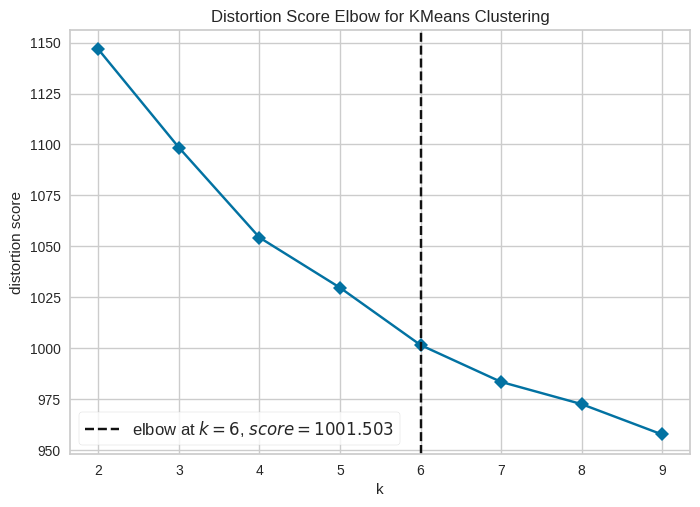

🔍 Optimal number of clusters (K): 6
[np.float64(1146.661502301911), np.float64(1098.4379803102818), np.float64(1054.2911942886267), np.float64(1029.662467849395), np.float64(1001.5034473432777), np.float64(983.4019447685438), np.float64(972.4929700910862), np.float64(957.5799510946034)]


In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

model = KMeans(random_state=42)  # Here i am setting up KMeans Model

#set up the elbow visualizer
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)

# Fit visualizer to training_normalized embeddings
visualizer.fit(normalized_embeddings_training)
visualizer.show()

# Find Best K
best_k = visualizer.elbow_value_
print(f"🔍 Optimal number of clusters (K): {best_k}")


# Creates a new KMeans model using the best K from the elbow plot.
#Fits the model and predicts cluster labels for each data point.
#cluster_labels is an array indicating which cluster each embedding belongs to
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_embeddings_training)

#Distortion score tells how far apart the data is from its assigned cluster center.
#Lower score means more tighter compact clusters which is good.
print(visualizer.k_scores_)


In [27]:
print(cluster_labels.shape)


(2470,)


# Lets perform distance to centroid classification or Post Clustering Prediction.

In [28]:
'''
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

def assign_cluster_to_embedding(embedding, kmeans_model, normalize_input=True):

    # Ensure input is a NumPy array
    y = np.array(embedding, dtype=float).reshape(1, -1)

    # Normalize if needed
    if normalize_input:
        from sklearn.preprocessing import normalize
        y = normalize(y, norm='l2')

    # Compute Euclidean distances to all centroids
    distances = euclidean_distances(y, kmeans_model.cluster_centers_)

    # Find nearest cluster
    cluster_id = np.argmin(distances)
    min_distance = distances[0, cluster_id]

    return cluster_id, min_distance
'''

"\nimport numpy as np\nfrom sklearn.metrics.pairwise import euclidean_distances\n\ndef assign_cluster_to_embedding(embedding, kmeans_model, normalize_input=True):\n\n    # Ensure input is a NumPy array\n    y = np.array(embedding, dtype=float).reshape(1, -1)\n\n    # Normalize if needed\n    if normalize_input:\n        from sklearn.preprocessing import normalize\n        y = normalize(y, norm='l2')\n\n    # Compute Euclidean distances to all centroids\n    distances = euclidean_distances(y, kmeans_model.cluster_centers_)\n\n    # Find nearest cluster\n    cluster_id = np.argmin(distances)\n    min_distance = distances[0, cluster_id]\n\n    return cluster_id, min_distance\n"

# Use the trained KMeans model to assign each test embedding to its nearest cluster centroid

In [29]:
import numpy as np
import ast
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import euclidean_distances

# Parse & Normalize embeddings from df_test['embeddings']
parsed_test_embeddings = []

for emb in df_test['embeddings']:
    if isinstance(emb, str):
        emb = ast.literal_eval(emb)
    arr = np.array(emb, dtype=float)
    if arr.ndim == 2 and arr.shape[0] == 1:
        arr = arr.squeeze(axis=0)
    parsed_test_embeddings.append(arr)

# Convert to matrix and normalize
test_embeddings_np = np.vstack(parsed_test_embeddings)
normalized_test_embeddings = normalize(test_embeddings_np, norm='l2')

# Define a helper function to assign cluster to an embedding based on Euclidean Distance
def assign_cluster_to_embedding(embedding, kmeans_model):
    """
    Assigns embedding to the closest cluster centroid.
    """
    embedding = embedding.reshape(1, -1)  # Reshape to 2D
    distances = euclidean_distances(embedding, kmeans_model.cluster_centers_)
    cluster_id = np.argmin(distances)
    distance = distances[0, cluster_id]
    return cluster_id, distance

# Apply the function to each test embedding
assigned_clusters = []
distances_to_centroids = []

for emb in normalized_test_embeddings:
    cluster_id, dist = assign_cluster_to_embedding(emb, kmeans)
    assigned_clusters.append(cluster_id)
    distances_to_centroids.append(dist)

# Add results to df_test
df_test['assigned_cluster'] = assigned_clusters
df_test['distance_to_centroid'] = distances_to_centroids


print(df_test[['assigned_cluster', 'distance_to_centroid']].head())


   assigned_cluster  distance_to_centroid
0                 0              0.631537
1                 1              0.654049
2                 5              0.614892
3                 4              0.684639
4                 3              0.632818


# Build a majority Voting map from the training set

Below code we will be converting unsupervised clustering into pseudo labeling, that makes you make label predictions based on majority voting within each cluster. It will take the cluster_labels for the training data and the corresponding true labels and it will create a mapping like, Each cluster → the most common (majority) label in that cluster

In [30]:

df_train['cluster'] = cluster_labels
cluster_to_label = (
    df_train.groupby('cluster')['label']
    .agg(lambda x: x.value_counts().idxmax()) #Selects the label that appears most frequently = majority vote
    .to_dict()
)

#we now have the A dictionary that maps: each cluster ID → the most common label among training samples in that cluster

Use the majority label for each test sample’s assigned cluster

In [31]:
# Assign predicted label based on cluster's majority vote
df_test['predicted_label'] = df_test['assigned_cluster'].map(cluster_to_label)


Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.6846    0.7278    0.7056       349
           1     0.6154    0.5651    0.5891       269

    accuracy                         0.6570       618
   macro avg     0.6500    0.6464    0.6474       618
weighted avg     0.6545    0.6570    0.6549       618



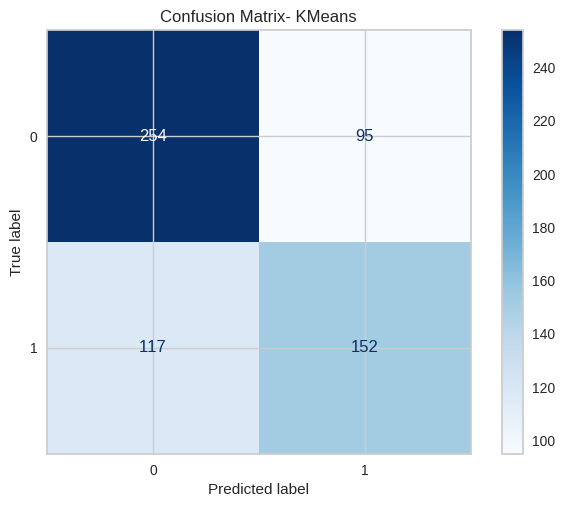

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Compare with ground truth
print("Classification Report (Test Set):")
print(classification_report(df_test['label'], df_test['predicted_label'], digits=4))

# Confusion Matrix
cm = confusion_matrix(df_test['label'], df_test['predicted_label'])
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix- KMeans")
plt.show()


Summary from the above code:
1. Which cluster each test embedding belongs to (by Euclidean distance)
2. Dictionary of majority-vote label for each cluster
3. Assigned test label based on its cluster’s majority class
4. This approach has turned the unsupervised clustering into a Semi Supervised classification problem.

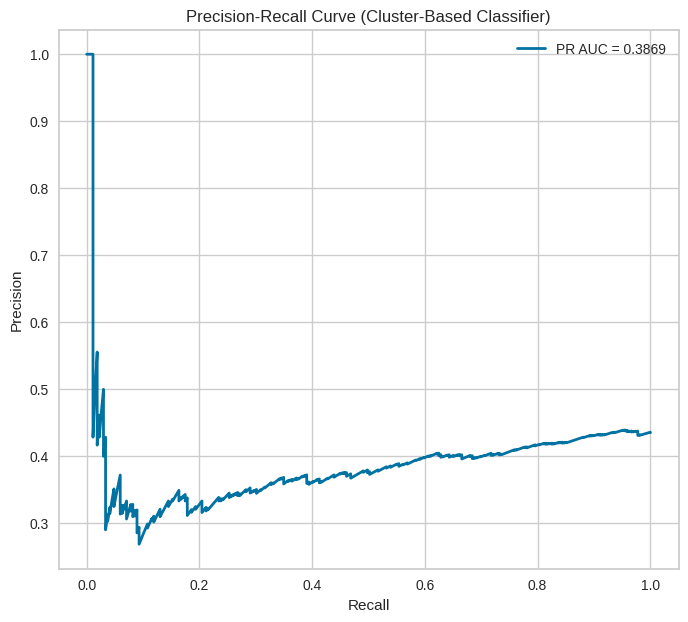

In [33]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Choose which class you want to treat as the "positive" class
positive_label = 1  # e.g., AI-generated

# Convert ground truth and predictions to binary (0 = not positive, 1 = positive)
y_true_binary = (df_test['label'] == positive_label).astype(int)
y_pred_binary = (df_test['predicted_label'] == positive_label).astype(int)

# Use distance to centroid as a confidence score (lower distance = higher confidence)
cluster_distances = df_test['distance_to_centroid'].values
max_dist = cluster_distances.max()
confidence_scores = 1 - (cluster_distances / max_dist)  # Normalize to [0, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true_binary, confidence_scores)
pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure(figsize=(8, 7))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Cluster-Based Classifier)")
plt.grid(True)
plt.legend()
plt.show()


Summary from Precsion recall Curve
1. Precision- Of all the items the model labeled as positive, how many were actually positive.
2. Recall - Of all the actual positives, how many did the model correctly identify.
3. initially high precision and very low recall, as recall increases precision quickly drops.
all above indicates the model has limited ability to distinguish the positive class from negative class.